## LangGraph 자세히 알아보기
Human In the Loop를 통해 직접 개입하기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_tavily.tavily_search import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

from langgraph.checkpoint.memory import MemorySaver

### 기억력 만들기

In [3]:
memory = MemorySaver()

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


tool = TavilySearch(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State) -> State:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["tools"])

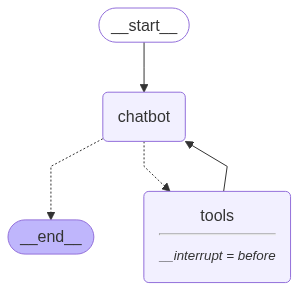

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 테스트 해보기

In [7]:
user_input = "Langgraph가 뭐야?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Langgraph가 뭐야?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_q7LI6dv8pujo9alRdWEq4n0e)
 Call ID: call_q7LI6dv8pujo9alRdWEq4n0e
  Args:
    query: Langgraph
    search_depth: advanced
